# Tutorial 5 : Exponential Smoothing

### Load all Python Modules

In [1]:
! pip install statsmodels==0.12.1

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1


### Load all packages

In [2]:
%reset -f

import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools   import adfuller

### Graph Settings

In [3]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

### Load Data

In [5]:
df = pd.read_csv('ausunemp.csv')
df.index = pd.date_range(start='1990-01-01', periods=355, freq='M')
df.drop(['month'], axis=1, inplace=True)

df = df.rename(columns={"Unemployment rate (percentage; source: ABS)": "data"})

In [15]:
df.head()

,unemp,z_data,zp_data
1990-01-31,6.7,NaN,NaN
1990-02-28,7.1,NaN,NaN
1990-03-31,6.5,NaN,NaN
1990-04-30,6.3,NaN,NaN
1990-05-31,6.5,NaN,NaN


In [7]:
df.index

DatetimeIndex(['1990-01-31', '1990-02-28', '1990-03-31', '1990-04-30',
               '1990-05-31', '1990-06-30', '1990-07-31', '1990-08-31',
               '1990-09-30', '1990-10-31',
               ...
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31'],
              dtype='datetime64[ns]', length=355, freq='M')

### (a). Holt-Winters Method

##### If the series is stationary, the MA and Moving std should be hovering around some constant value

In [16]:
### calculating rolling mean
df['z_data'] = (df['unemp'] - df.unemp.rolling(window=4).mean()) / df.unemp.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(1)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].scatter(df.index, df.unemp, color='c', label='raw data')
    ax[0].plot(df.unemp.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.unemp.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

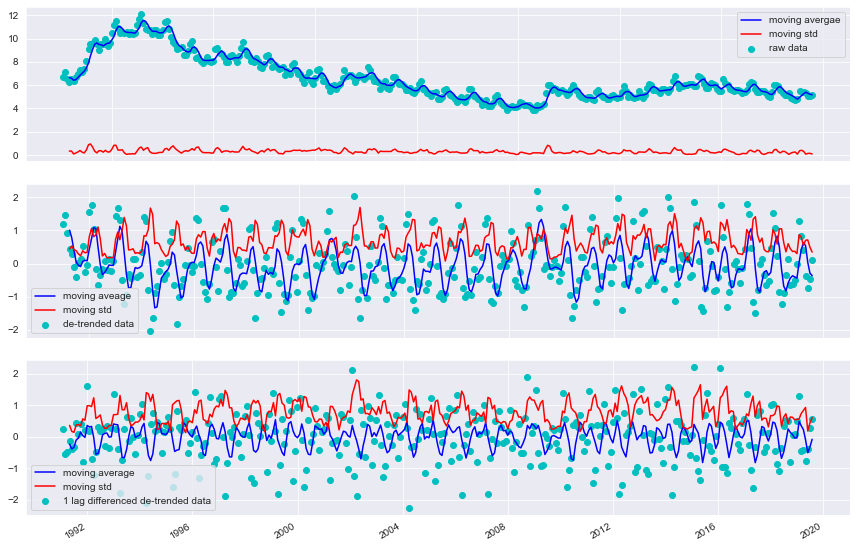

In [17]:
plot_rolling(df)

###### running an ADF test using AIC to auto determine the max lag terms

In [18]:
print(" > Is the data stationary ?")
dftest = adfuller(df.unemp.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 1-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
  print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -2.553
P-value = 0.103
Critical values :
	1%: -3.449673193310592 - The data is not stationary with 99% confidence
	5%: -2.8700533746644323 - The data is not stationary with 95% confidence
	10%: -2.5713055939491403 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -4.633
P-value = 0.000
Critical values :
	1%: -3.4505694423906546 - The data is  stationary with 99% confidence
	5%: -2.8704469462727795 - The data is  stationary with 95% confidence
	10%: -2.5715154495841017 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -6.252
P-value = 0.000
Critical values :
	1%: -3.4504451681828194 - The data is  stationary with 99% confidence
	5%: -2.870392380216117 - The data is  stationary with 95% confidence
	10%: -2.571486353732897 - The data is  stationary with 90% confidence


###### Simple exponential Smoothing Model (no trend)

In [19]:
model_simple = SimpleExpSmoothing(np.asarray(df['unemp']), initialization_method='estimated')
model_simple._index = pd.to_datetime(df.index)

fit_simple = model_simple.fit(optimized=True)
fore_simple = fit_simple.forecast(60)

fit_simple.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,SimpleExpSmoothing,SSE,45.330
Optimized:,True,AIC,-726.643
Trend:,None,BIC,-718.899
Seasonal:,None,AICC,-726.529
Seasonal Periods:,None,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:44:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,6.6994906,l.0,True


In [20]:
fore_simple

array([5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2,
       5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2, 5.2])

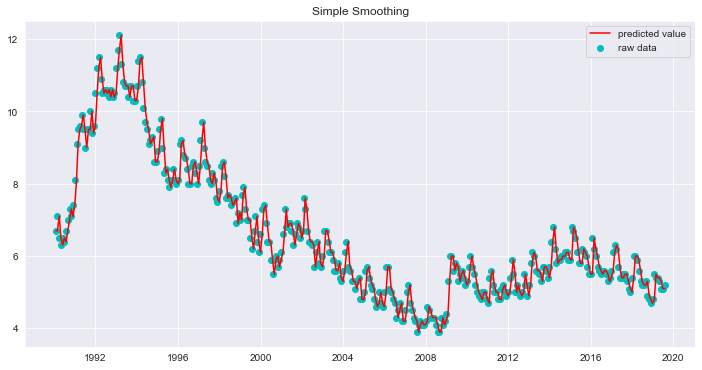

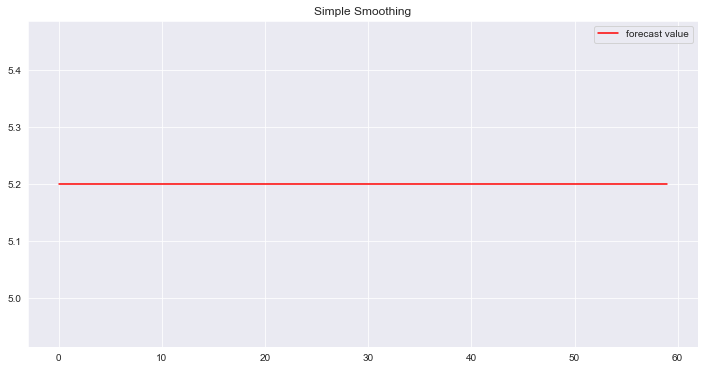

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, fit_simple.fittedvalues, label="predicted value", color='r')
ax.scatter(df.index, df.unemp, color='c', label='raw data')

plt.title("Simple Smoothing")    
plt.legend();

fig1 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_simple, label="forecast value", color='r')
plt.title("Simple Smoothing")    
plt.legend();

###### Hotl's linear trend smoothing

In [23]:
model_Holt_1 = Holt(np.asarray(df['unemp']), initialization_method="estimated")
model_Holt_1._index = pd.to_datetime(df.index)

fit_Holt_1  = model_Holt_1.fit(optimized=True)
fore_Holt_1 = fit_Holt_1.forecast(60)

fit_Holt_1.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,Holt,SSE,45.324
Optimized:,True,AIC,-722.693
Trend:,Additive,BIC,-707.204
Seasonal:,None,AICC,-722.451
Seasonal Periods:,None,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:51:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,2.1947e-13,beta,True


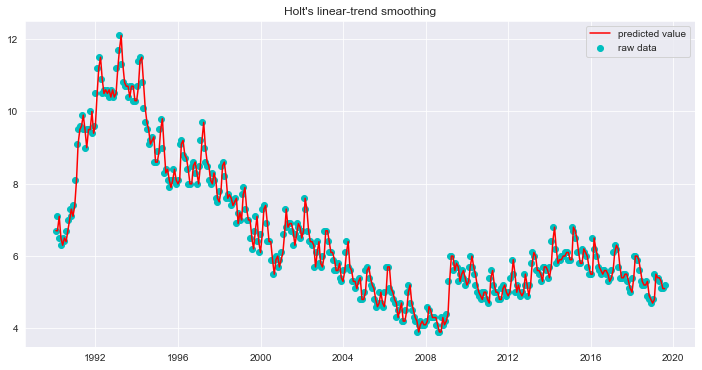

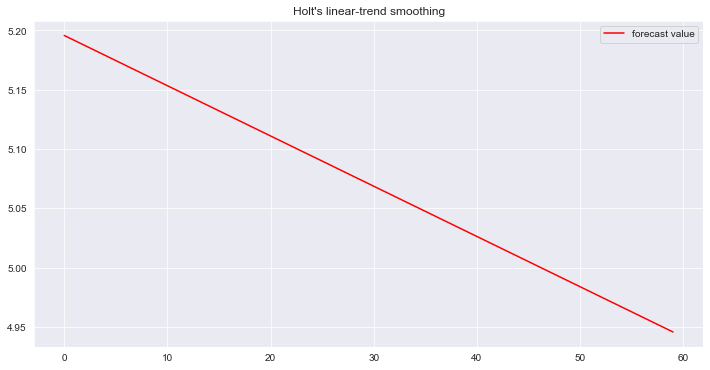

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, fit_Holt_1.fittedvalues, color='r', label='predicted value')
ax.scatter(df.index, df.unemp, color='c', label='raw data')

plt.title("Holt's linear-trend smoothing")
plt.legend();

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_Holt_1, label="forecast value", color='r')
plt.title("Holt's linear-trend smoothing")    
plt.legend();

### (b). Gardner-McKenzie Method

###### Holt's Damped trend smoothing

###### Use the multiplactive verion, unless the data has been logged bfore, otherwise use additive

In [26]:
model_Holt_2 = ExponentialSmoothing(np.asarray(df['unemp']), trend='mul', seasonal=None, initialization_method="estimated") 
model_Damp_2 = ExponentialSmoothing(np.asarray(df['unemp']), trend='mul', seasonal=None, damped_trend = True, initialization_method="estimated")
model_Holt_2._index = pd.to_datetime(df.index)
model_Damp_2._index = pd.to_datetime(df.index)

fit_Holt_2 = model_Holt_2.fit()
fit_Damp_2 = model_Damp_2.fit()
fit_Holt_2.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,45.270
Optimized:,True,AIC,-723.111
Trend:,Multiplicative,BIC,-707.622
Seasonal:,None,AICC,-722.870
Seasonal Periods:,None,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:53:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [27]:
fit_Damp_2.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,44.980
Optimized:,True,AIC,-723.394
Trend:,Multiplicative,BIC,-704.034
Seasonal:,None,AICC,-723.071
Seasonal Periods:,None,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:53:37
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


In [28]:
fore_Holt_2 = fit_Holt_2.forecast(60)
fore_Damp_2 = fit_Damp_2.forecast(60)

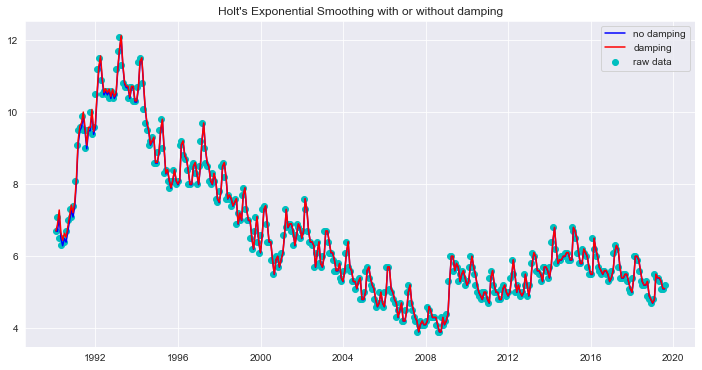

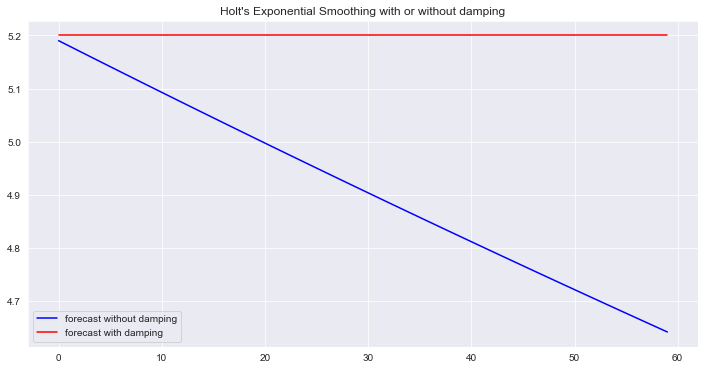

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(df.index, df.unemp, c='c', label='raw data')
ax.plot(df.index, fit_Holt_2.fittedvalues, color='b', label="no damping")
ax.plot(df.index, fit_Damp_2.fittedvalues, color='r', label="damping")

plt.title("Holt's Exponential Smoothing with or without damping") 
plt.legend()

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_Holt_2, label="forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_Damp_2, label="forecast with damping", color='r')
plt.title("Holt's Exponential Smoothing with or without damping")    
plt.legend();

###### Holt-Winters Seasonal Smoothing (with and without damping)

In [31]:
model_season_Holt = ExponentialSmoothing(np.asarray(df['unemp']), trend="mul", seasonal="mul", seasonal_periods=12, initialization_method="estimated")
model_season_Damp = ExponentialSmoothing(np.asarray(df['unemp']), trend="mul", seasonal="mul", seasonal_periods=12, damped_trend=True, initialization_method="estimated")
model_season_Holt._index = pd.to_datetime(df.index)
model_season_Damp._index = pd.to_datetime(df.index)

fit_season_Holt = model_season_Holt.fit()
fit_season_Damp = model_season_Damp.fit()
fore_season_Holt = fit_season_Holt.forecast(60)
fore_season_Damp = fit_season_Damp.forecast(60)

In [32]:
fit_season_Holt.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,15.108
Optimized:,True,AIC,-1088.698
Trend:,Multiplicative,BIC,-1026.744
Seasonal:,Multiplicative,AICC,-1086.663
Seasonal Periods:,12,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:56:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6819691,alpha,True
smoothing_trend,0.1328241,beta,True


In [33]:
fit_season_Damp.summary()

Dep. Variable:,endog,No. Observations:,355
Model:,ExponentialSmoothing,SSE,14.311
Optimized:,True,AIC,-1105.934
Trend:,Multiplicative,BIC,-1040.108
Seasonal:,Multiplicative,AICC,-1103.665
Seasonal Periods:,12,Date:,"Sat, 03 Sep 2022"
Box-Cox:,False,Time:,10:56:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6857679,alpha,True
smoothing_trend,0.0666916,beta,True


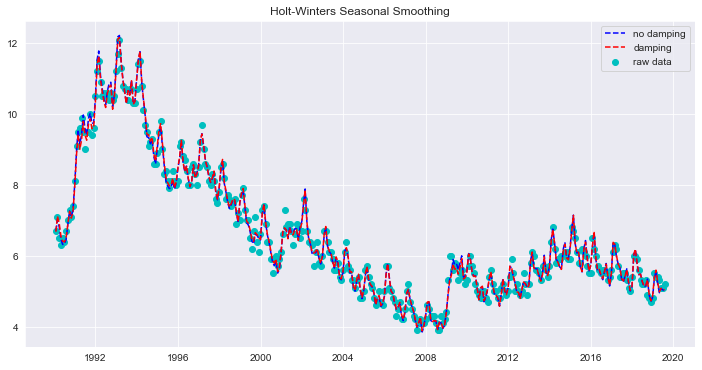

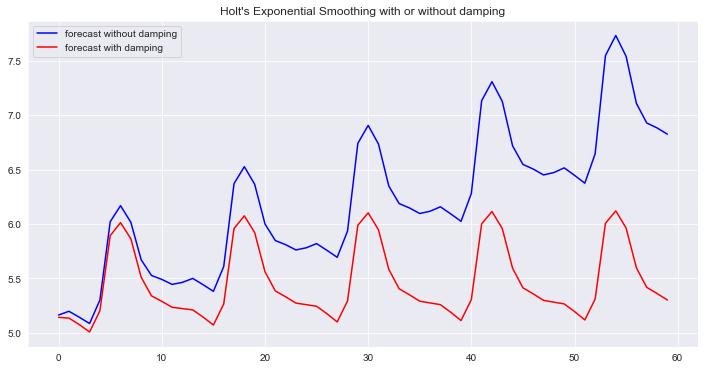

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.index, df.unemp, color ='c', label='raw data');
ax.plot(df.index, fit_season_Holt.fittedvalues, linestyle='--', color='b', label="no damping")
ax.plot(df.index, fit_season_Damp.fittedvalues, linestyle='--', color='r', label="damping")
ax.legend();
ax.set_title("Holt-Winters Seasonal Smoothing");

fig2 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_season_Holt, label="forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_season_Damp, label="forecast with damping", color='r')
plt.title("Holt's Exponential Smoothing with or without damping")    
plt.legend();

### (c). Plotting them all

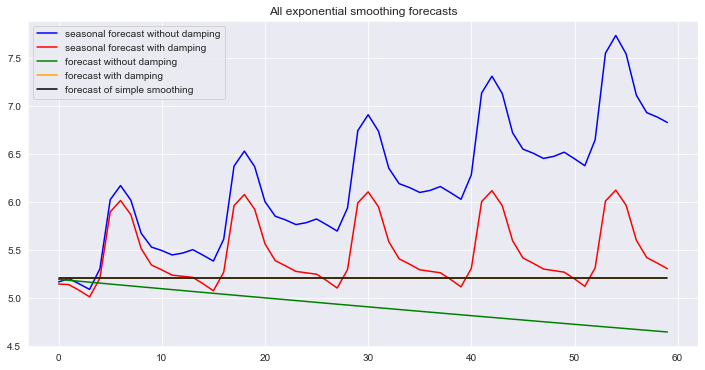

In [35]:
fig3 = plt.subplots(figsize=(12, 6))
plt.plot(np.arange(0,60), fore_season_Holt, label="seasonal forecast without damping", color='b')
plt.plot(np.arange(0,60), fore_season_Damp, label="seasonal forecast with damping"   , color='r')
plt.plot(np.arange(0,60), fore_Holt_2     , label="forecast without damping"       , color='g')
plt.plot(np.arange(0,60), fore_Damp_2     , label="forecast with damping"          , color='orange')
plt.plot(np.arange(0,60), fore_simple     , label="forecast of simple smoothing"     , color='k')
plt.title("All exponential smoothing forecasts")    
plt.legend();